<h1 style="text-align: center; color: #E30613;"><b><i>Entraînement avec LSTM sur les Données de Sentiments</i></b></h1>

<p style="font-size: 18px; color: #333;">
Ce notebook présente une approche complète pour l'entraînement d'un modèle LSTM (Long Short-Term Memory) sur des données de sentiments.
L'objectif est de prédire les sentiments exprimés dans des commentaires textuels en utilisant des techniques avancées de traitement du langage naturel (NLP).
</p>

### <span style="color: #28A745;">**Étapes principales du workflow :**</span>

1. **Chargement des données :** Importation et nettoyage des données textuelles.
2. **Encodage des étiquettes :** Transformation des sentiments en valeurs numériques.
3. **Division des données :** Séparation des données en ensembles d'entraînement, de validation et de test.
4. **Vectorisation :** Conversion des textes en vecteurs numériques à l'aide de `CountVectorizer`.
5. **Création d'un Dataset personnalisé :** Préparation des données pour le DataLoader de PyTorch.
6. **Définition du modèle LSTM :** Construction et configuration du modèle LSTM pour la classification.
7. **Entraînement :** Optimisation des paramètres du modèle à l'aide de la descente de gradient.
8. **Évaluation :** Analyse des performances du modèle avec des métriques et des visualisations.

### <span style="color: #28A745;">**Technologies utilisées :**</span>

- **PyTorch :** Framework pour la construction et l'entraînement du modèle LSTM.
- **Scikit-learn :** Prétraitement des données et évaluation des performances.
- **Matplotlib & Seaborn :** Visualisation des résultats et des métriques.
- **TQDM :** Suivi des progrès pendant l'entraînement.

<p style="font-size: 16px; color: #555;">
<b>Note :</b> Ce projet est conçu pour démontrer une approche pratique et reproductible pour l'analyse des sentiments à l'aide de réseaux de neurones récurrents.
</p>

# <span style="color: #E30613;">**LSTM**</span>

## <span style="color: #28A745;">**Bibiliothèques nécessaires**</span>

In [3]:
%pip install torch torchvision torchaudio scikit-learn matplotlib tqdm pandas

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


## <span style="color: #28A745;">**Utilisation de GPU**</span>

In [5]:
# ✅ GPU seulement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## <span style="color: #28A745;">**Chargement des Données**</span>

In [ ]:
# 📁 Chargement des données
df = pd.read_csv("/content/Results/Comments_clean.csv")
df = df.dropna(subset=["Comments"])

## <span style="color: #28A745;">**Encodage des étiquettes**</span>

In [8]:
# 🎯 Encodage des étiquettes
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])

## <span style="color: #28A745;">**Division des données**</span>

In [9]:
# ✂️ Division des données
X_temp, X_test, y_temp, y_test = train_test_split(df["Comments"], df["Sentiments_encoded"], test_size=0.2, random_state=42, stratify=df["Sentiments_encoded"])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)  # 0.125 * 0.8 = 0.1

## <span style="color: #28A745;">**Vectorisation avec CountVectorizer**</span>

In [10]:
# 🧠 Vectorisation avec CountVectorizer
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train).toarray()
X_val_vec = vectorizer.transform(X_val).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

## <span style="color: #28A745;">**Dataset personnalisé**</span>

In [12]:
# 📦 Dataset personnalisé
class CommentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CommentDataset(X_train_vec, y_train)
val_dataset = CommentDataset(X_val_vec, y_val)
test_dataset = CommentDataset(X_test_vec, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## <span style="color: #28A745;">**Entraînement avec LSTM**</span>

In [ ]:
# 🧱 Modèle LSTM
class SentimentLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
        super(SentimentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch_size, 1, input_dim]
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(out)
        return self.softmax(out)

input_dim = X_train_vec.shape[1]
model = SentimentLSTM(input_dim=input_dim, hidden_dim=128, output_dim=3, n_layers=2, dropout=0.5)
model = model.to(device)

# 🔧 Entraînement
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0009, weight_decay=1e-5, eps=0.00001)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_val_loss = float('inf')
patience = 2  # Nombre d'époques sans amélioration avant l'arrêt anticipé
epochs_no_improve = 0

for epoch in range(100):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "/content/Results/best_model_LSTM.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("⛔ Early stopping triggered")
            break

Epoch 1 [Training]: 100%|██████████| 80/80 [00:01<00:00, 53.46it/s, loss=1.27] 



Epoch 1 - Train Loss: 1.0746, Val Loss: 1.0120, Train Acc: 0.4191, Val Acc: 0.4503


Epoch 2 [Training]: 100%|██████████| 80/80 [00:01<00:00, 54.26it/s, loss=1.04] 



Epoch 2 - Train Loss: 0.9150, Val Loss: 0.8743, Train Acc: 0.6121, Val Acc: 0.6685


Epoch 3 [Training]: 100%|██████████| 80/80 [00:01<00:00, 56.56it/s, loss=0.552]



Epoch 3 - Train Loss: 0.7871, Val Loss: 0.7917, Train Acc: 0.8114, Val Acc: 0.7845


Epoch 4 [Training]: 100%|██████████| 80/80 [00:01<00:00, 53.05it/s, loss=0.575]



Epoch 4 - Train Loss: 0.6836, Val Loss: 0.7466, Train Acc: 0.8901, Val Acc: 0.8149


Epoch 5 [Training]: 100%|██████████| 80/80 [00:01<00:00, 50.19it/s, loss=0.552]



Epoch 5 - Train Loss: 0.6423, Val Loss: 0.7323, Train Acc: 0.9178, Val Acc: 0.8315


Epoch 6 [Training]: 100%|██████████| 80/80 [00:01<00:00, 49.30it/s, loss=0.749]



Epoch 6 - Train Loss: 0.6211, Val Loss: 0.7261, Train Acc: 0.9375, Val Acc: 0.8177


Epoch 7 [Training]: 100%|██████████| 80/80 [00:01<00:00, 54.01it/s, loss=0.552]



Epoch 7 - Train Loss: 0.6121, Val Loss: 0.7234, Train Acc: 0.9442, Val Acc: 0.8343


Epoch 8 [Training]: 100%|██████████| 80/80 [00:01<00:00, 52.72it/s, loss=0.551]



Epoch 8 - Train Loss: 0.6018, Val Loss: 0.7179, Train Acc: 0.9545, Val Acc: 0.8370


Epoch 9 [Training]: 100%|██████████| 80/80 [00:01<00:00, 46.87it/s, loss=0.551]



Epoch 9 - Train Loss: 0.5992, Val Loss: 0.7183, Train Acc: 0.9557, Val Acc: 0.8260


Epoch 10 [Training]: 100%|██████████| 80/80 [00:01<00:00, 46.13it/s, loss=0.551]



Epoch 10 - Train Loss: 0.5978, Val Loss: 0.7158, Train Acc: 0.9561, Val Acc: 0.8343


Epoch 11 [Training]: 100%|██████████| 80/80 [00:01<00:00, 46.26it/s, loss=0.551]



Epoch 11 - Train Loss: 0.5942, Val Loss: 0.7161, Train Acc: 0.9597, Val Acc: 0.8315


Epoch 12 [Training]: 100%|██████████| 80/80 [00:01<00:00, 43.48it/s, loss=0.551]



Epoch 12 - Train Loss: 0.5904, Val Loss: 0.7160, Train Acc: 0.9636, Val Acc: 0.8287
⛔ Early stopping triggered


## <span style="color: #28A745;">**Graphique des pertes**</span>

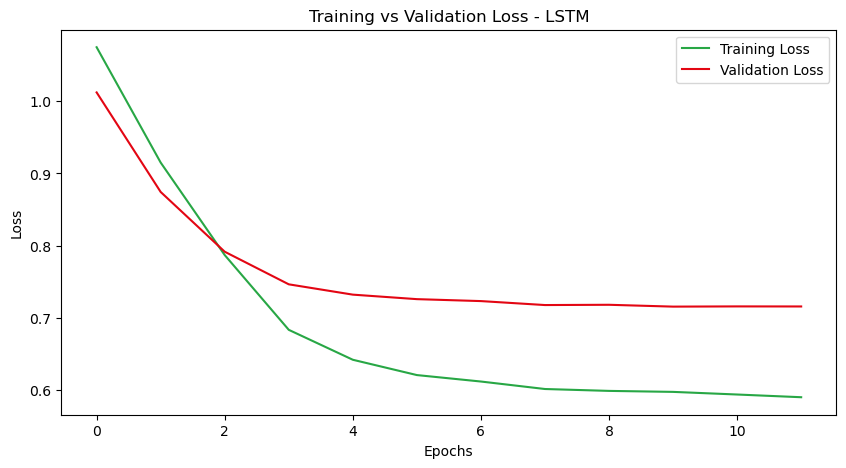

In [16]:
# 📉 Graphique des pertes
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", color='#28A745')
plt.plot(val_losses, label="Validation Loss", color='#E30613')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - LSTM")
plt.legend()
plt.show()

## <span style="color: #28A745;">**Évaluation finale**</span>

In [ ]:
# ✅ Évaluation finale
model.load_state_dict(torch.load("/content/Results/best_model_LSTM.pt"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 📊 Rapport de classification
print("\n🔍 Rapport de classification pour LSTM:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

C:\Users\kikoo\AppData\Local\Temp\ipykernel_27876\3566478200.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("content/Results/best_model


🔍 Rapport de classification pour LSTM:
              precision    recall  f1-score   support

     Negatif       0.92      0.85      0.88       172
      Neutre       0.80      0.83      0.82       236
     Positif       0.91      0.92      0.91       315

    accuracy                           0.88       723
   macro avg       0.88      0.87      0.87       723
weighted avg       0.88      0.88      0.88       723



## <span style="color: #28A745;">**Matrice de confusion**</span>

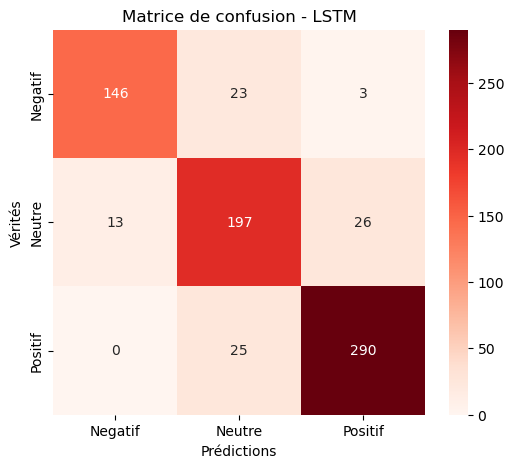

In [19]:
# 📌 Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion - LSTM")
plt.show()

<h3 style="text-align: center; color: #E30613;"><b><i>Développé par: OUARAS Khelil Rafik</i></b></h3>